In [15]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import random
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelBinarizer

from sklearn.model_selection import train_test_split
from sklearn import utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from xgboost import XGBClassifier

#Imports Packages

In [16]:
!pip install shap
# Installs visualization tool for explaining ML model outcomes

You should consider upgrading via the 'c:\users\17247\anaconda3\python.exe -m pip install --upgrade pip' command.


In [17]:
import shap

In [18]:
df = pd.read_csv("C:/Users/17247/DS 340W/ATP.csv")
df.shape
#169,690 entries, 49 features

(169690, 49)

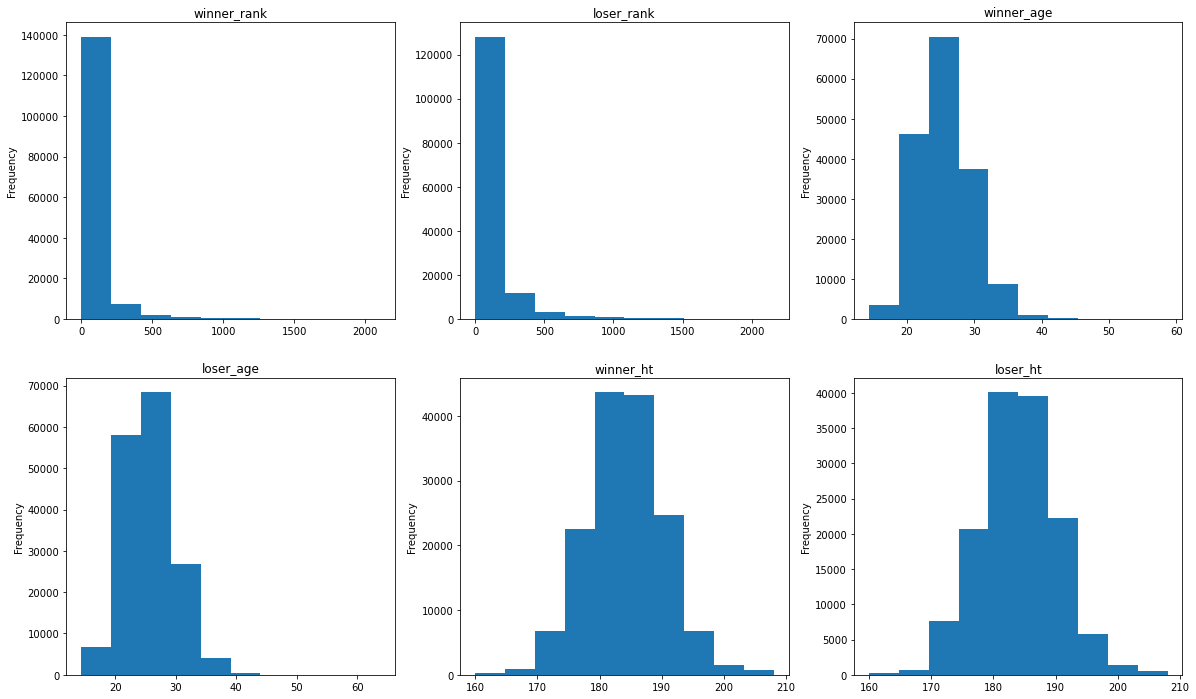

In [19]:
dimensions = ['winner_rank','loser_rank','winner_age','loser_age','winner_ht','loser_ht']

plt.figure(1, figsize=(20,12))

for i in range(1,7):
    plt.subplot(2,3,i)
    df[dimensions[i-1]].plot(kind='hist', title=dimensions[i-1])
#Bar graphs for rank of the winner of a tennis match, rank of a loser, age of the winner, age of the loser, height (in centimeters) of the winner, and height (in cm) of the loser

Text(0.5, 1.0, '10 Top players')

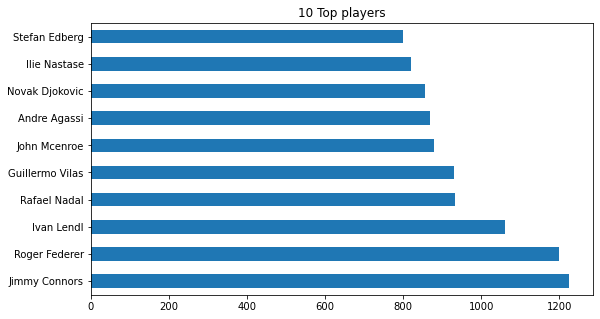

In [20]:
plt.figure(figsize=(9,5))
df['winner_name'].value_counts()[:10].plot(kind='barh')
plt.title('10 Top players')
#Horizontal bar graph of top 10 players by most won matches in their career

<AxesSubplot:>

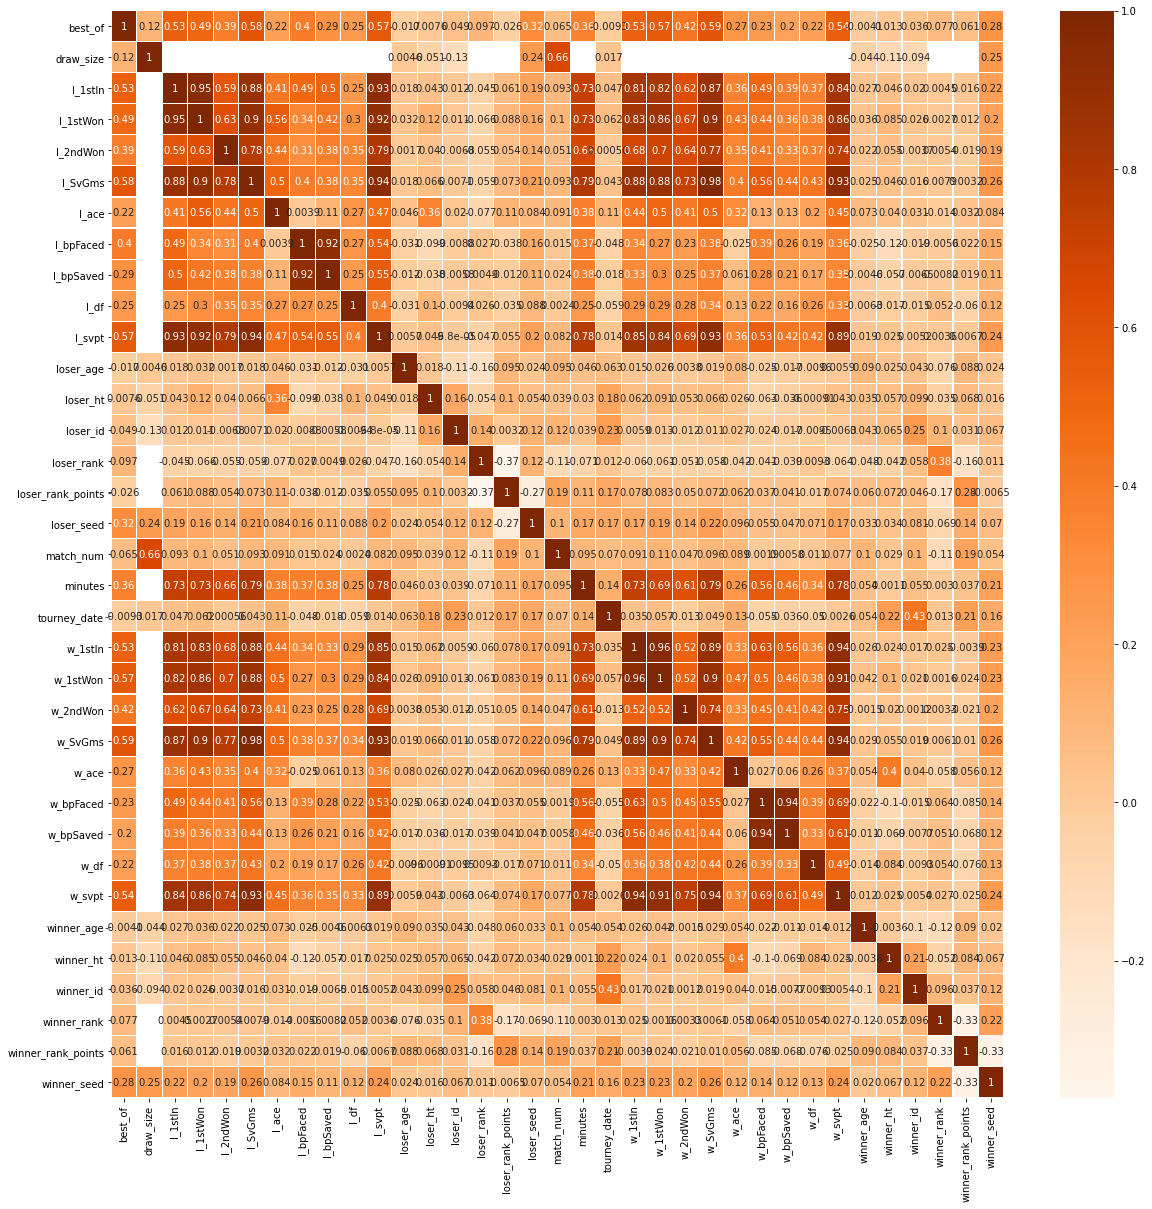

In [21]:
correlation_matrix = df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, annot= True, linewidth=0.1, cmap= 'Oranges')
#Correlation matrix of all features i ndataset

In [22]:
df = df.drop(columns=['score','tourney_name','winner_name',
                      'loser_name','minutes', 'l_1stIn', 'l_1stWon', 'l_2ndWon','l_ace', 'l_svpt',
                      'l_SvGms','l_bpFaced','l_df', 'l_bpSaved',  'w_1stIn', 'w_1stWon','w_2ndWon', 'w_SvGms',
                      'w_ace', 'w_svpt','w_bpFaced', 'w_bpSaved','w_df'])
print("remained features ", df.columns)
#Drops unnecessary columns, keeps the ones listed below

remained features  Index(['best_of', 'draw_size', 'loser_age', 'loser_entry', 'loser_hand',
       'loser_ht', 'loser_id', 'loser_ioc', 'loser_rank', 'loser_rank_points',
       'loser_seed', 'match_num', 'round', 'surface', 'tourney_date',
       'tourney_id', 'tourney_level', 'winner_age', 'winner_entry',
       'winner_hand', 'winner_ht', 'winner_id', 'winner_ioc', 'winner_rank',
       'winner_rank_points', 'winner_seed'],
      dtype='object')


In [23]:
none_percent = df.isnull().sum() * 100 / len(df)
none_values_df = pd.DataFrame({'Feature name': df.columns, 'None values count': df.isnull().sum(),
                                 'None values percent': none_percent})
print(none_values_df.reset_index().drop(columns=['index']))
#Counts number of none values in each feature

          Feature name  None values count  None values percent
0              best_of                  0             0.000000
1            draw_size             168458            99.273970
2            loser_age               4990             2.940656
3          loser_entry             144351            85.067476
4           loser_hand                 85             0.050091
5             loser_ht              30638            18.055277
6             loser_id                  0             0.000000
7            loser_ioc                  0             0.000000
8           loser_rank              23781            14.014379
9    loser_rank_points              76665            45.179445
10          loser_seed             136837            80.639401
11           match_num                  0             0.000000
12               round                  0             0.000000
13             surface               2539             1.496258
14        tourney_date                  0             0

In [24]:
features_to_remove = none_values_df[none_values_df["None values percent"] > 85]
print(features_to_remove)
df = df.drop(columns=features_to_remove['Feature name'].values)
#Drops columns with none values greater than 85%, which are draw size, winner entry, and loser entry

              Feature name  None values count  None values percent
draw_size        draw_size             168458            99.273970
loser_entry    loser_entry             144351            85.067476
winner_entry  winner_entry             154942            91.308857


In [25]:
df.dropna(subset=['winner_rank_points', 'loser_rank_points','winner_rank','loser_rank', 'surface'], inplace=True)
df = df.reset_index(drop=True)
df
#Drops null entries for winner and loser rank points, winner and loser rank, and the court surface type

best_of  loser_age loser_hand  loser_ht  loser_id loser_ioc  \
0            3      20.40          R     190.0    101632       SWE   
1            3      25.01          L     190.0    101096       RSA   
2            3      23.90          R     183.0    101232       SWE   
3            3      21.94          L     190.0    101434       CZE   
4            3      22.35          R     180.0    101387       ITA   
...        ...        ...        ...       ...       ...       ...   
92452        3      31.78          R     188.0    104919       ARG   
92453        3      25.69          R       NaN    106198       BOL   
92454        3      23.73          R       NaN    111513       SRB   
92455        3      20.18          R       NaN    134770       NOR   
92456        3      22.74          R       NaN    106426       CHI   

       loser_rank  loser_rank_points  loser_seed  match_num  ... tourney_id  \
0           282.0               70.0         NaN          1  ...   1990-339   
1           127.0              182.0         NaN          2  ...   1990-339   
2            71.0              290.0         NaN          3  ...   1990-339   
3            80.0              271.0         NaN          4  ...   1990-339   
4           100.0              224.0         NaN          5  ...   1990-339   
...           ...                ...         ...        ...  ...        ...   
92452        55.0              895.0         4.0        296  ...  2019-0533   
92453        95.0              600.0         NaN        297  ...  2019-0533   
92454        37.0             1127.0         NaN        298  ...  2019-0533   
92455       108.0              527.0         NaN        299  ...  2019-0533   
92456        92.0              620.0         NaN        300  ...  2019-0533   

      tourney_level  winner_age winner_hand winner_ht  winner_id winner_ioc  \
0                 A       18.96           R     188.0     101843        ESP   
1                 A       29.00           L     183.0     100714        AUS   
2                 A       21.20           R     193.0     101529        GER   
3                 A       30.23           R     201.0     100628        NED   
4                 A       22.25           L     180.0     101404        AUT   
...             ...         ...         ...       ...        ...        ...   
92452             A       22.74           R       NaN     106426        CHI   
92453             A       20.18           R       NaN     134770        NOR   
92454             A       28.78           L     185.0     105550        ARG   
92455             A       22.74           R       NaN     106426        CHI   
92456             A       28.78           L     185.0     105550        ARG   

       winner_rank  winner_rank_points winner_seed  
0             25.0               591.0         1.0  
1            146.0               157.0         NaN  
2            113.0               215.0         NaN  
3             68.0               297.0         7.0  
4             34.0               496.0         3.0  
...            ...                 ...         ...  
92452         92.0               620.0         NaN  
92453        108.0               527.0         NaN  
92454         48.0               975.0         3.0  
92455         92.0               620.0         NaN  
92456         48.0               975.0         3.0  

[92457 rows x 23 columns]

In [26]:
numeric_columns = ['winner_rank', 'loser_rank', 'winner_age', 'loser_age', 'winner_ht', 'loser_ht']
df[numeric_columns] = df[numeric_columns].astype(float)
#Changes numeric columns like winner and loser rank, age, and height to float type

In [27]:
df.tourney_date
#Shows the date for each match recorded in the dataframe

0        19900101
1        19900101
2        19900101
3        19900101
4        19900101
           ...   
92452    20190225
92453    20190225
92454    20190225
92455    20190225
92456    20190225
Name: tourney_date, Length: 92457, dtype: int64

In [28]:
#"tourney_date" is in the format of YYYYMMDD
df['tourney_year'] = df.tourney_date.astype(str).str[:4].astype(int)
df['tourney_month'] = df.tourney_date.astype(str).str[4:6].astype(int)
#Now drop "tourney_date"
df = df.drop(columns=['tourney_date'])

In [29]:
df = df.rename(columns={"loser_age": "first_age", "loser_entry": "first_entry", "loser_hand": "first_hand",
                        "loser_ht": "first_ht", "loser_id": "first_id", "loser_ioc": "first_ioc",
                        "loser_rank": "first_rank", "loser_rank_points": "first_rank_points",
                        "loser_seed": "first_seed",
                
                        "winner_age": "second_age", "winner_entry": "second_entry","winner_hand": "second_hand",
                        "winner_ht": "second_ht", "winner_id": "second_id", "winner_ioc": "second_ioc",
                        "winner_rank": "second_rank", "winner_rank_points": "second_rank_points",
                        "winner_seed": "second_seed",
                       },)
#Copies data so the first player is considered the loser and the second player considered the winner

In [30]:
copy_2_df = df.copy()
copy_2_df[[ 'first_age','first_hand','first_ht','first_id','first_ioc','first_rank','first_rank_points','first_seed',
            'second_age','second_hand','second_ht','second_id','second_ioc','second_rank','second_rank_points','second_seed']]\
=copy_2_df[['second_age','second_hand','second_ht','second_id','second_ioc','second_rank','second_rank_points','second_seed',
             'first_age','first_hand','first_ht','first_id','first_ioc','first_rank','first_rank_points','first_seed']]
#Does the same but inverses positions

In [31]:
winner_player2 = np.zeros(df.shape[0]) # second player wins so label=0
df['label'] = winner_player2


winner_player1 = np.ones(copy_2_df.shape[0]) # first player wins so label=1
copy_2_df['label'] = winner_player1 

df = pd.concat([df,copy_2_df])
#shuffle data
df = df.sample(frac=1).reset_index(drop=True)
df

best_of  first_age first_hand  first_ht  first_id first_ioc  \
0             3      24.01          L     183.0    101733       NED   
1             3      28.41          R     203.0    104731       RSA   
2             5      26.19          R     185.0    100997       BAH   
3             3      24.02          R     180.0    102374       ESP   
4             3      20.06          R       NaN    126207       USA   
...         ...        ...        ...       ...       ...       ...   
184909        3      30.13          L     175.0    103672       BRA   
184910        3      24.94          L     188.0    104547       ARG   
184911        5      26.84          R       NaN    104535       MEX   
184912        5      22.14          R     188.0    101890       USA   
184913        3      22.93          R     183.0    102694       GER   

        first_rank  first_rank_points  first_seed  match_num  ... second_hand  \
0             91.0              482.0         6.0         30  ...           R   
1             17.0             1875.0         3.0         18  ...           R   
2            259.0               81.0         NaN          1  ...           R   
3              8.0             2523.0         6.0         45  ...           R   
4             98.0              569.0         NaN        283  ...           U   
...            ...                ...         ...        ...  ...         ...   
184909        78.0              622.0         NaN         12  ...           R   
184910        54.0              801.0         6.0          3  ...           R   
184911       322.0              134.0         NaN          1  ...           R   
184912        57.0              670.0         NaN        101  ...           R   
184913       141.0              325.0         NaN         20  ...           R   

       second_ht second_id second_ioc  second_rank second_rank_points  \
0          180.0    100837        GBR        131.0              336.0   
1          193.0    106071        AUS         76.0              726.0   
2            NaN    101101        USA       1095.0                1.0   
3          183.0    102247        ITA         37.0             1047.0   
4            NaN    200624        USA        873.0               16.0   
...          ...       ...        ...          ...                ...   
184909     188.0    105053        COL         47.0              971.0   
184910     188.0    103758        USA        104.0              519.0   
184911       NaN    104763        ESA       1335.0                2.0   
184912     188.0    101222        SWE          3.0             2982.0   
184913     193.0    102854        NED         68.0              693.0   

        second_seed  tourney_year tourney_month  label  
0               NaN          1994             4    0.0  
1               NaN          2014            10    0.0  
2               NaN          1990             3    0.0  
3               NaN          1998             4    1.0  
4               NaN          2018             2    1.0  
...             ...           ...           ...    ...  
184909          NaN          2011             2    1.0  
184910          NaN          2010             4    1.0  
184911          NaN          2012             2    1.0  
184912          3.0          1993             5    0.0  
184913          NaN          1998            11    1.0  

[184914 rows x 25 columns]

In [32]:
hand_encoder = LabelEncoder()
df['first_hand'] = hand_encoder.fit_transform(df['first_hand'].astype(str))
df['second_hand'] = hand_encoder.transform(df['second_hand'].astype(str))

df['first_ioc'] = LabelEncoder().fit_transform(df['first_ioc'].astype(str))
df['second_ioc'] = LabelEncoder().fit_transform(df['second_ioc'].astype(str))

df['surface'] = LabelBinarizer().fit_transform(df['surface'].astype(str))
df['tourney_level'] = LabelEncoder().fit_transform(df['tourney_level'].astype(str))
df['tourney_id'] = LabelEncoder().fit_transform(df['tourney_id'].astype(str))
df['round'] = LabelEncoder().fit_transform(df['round'].astype(str))

df.info()
#Changes categorical variable type so they can work in the model

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184914 entries, 0 to 184913
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   best_of             184914 non-null  int64  
 1   first_age           184781 non-null  float64
 2   first_hand          184914 non-null  int32  
 3   first_ht            174647 non-null  float64
 4   first_id            184914 non-null  int64  
 5   first_ioc           184914 non-null  int32  
 6   first_rank          184914 non-null  float64
 7   first_rank_points   184914 non-null  float64
 8   first_seed          59187 non-null   float64
 9   match_num           184914 non-null  int64  
 10  round               184914 non-null  int32  
 11  surface             184914 non-null  int32  
 12  tourney_id          184914 non-null  int32  
 13  tourney_level       184914 non-null  int32  
 14  second_age          184781 non-null  float64
 15  second_hand         184914 non-nul

In [33]:
df_imputed = pd.DataFrame(SimpleImputer().fit_transform(df))
df_imputed.columns = df.columns
df_imputed.index = df.index
df = df_imputed.copy()
#Removes the rest of the none values

In [34]:
print('Final shape of data after cleaning and preprocessing: ', df.shape)

Final shape of data after cleaning and preprocessing:  (184914, 25)


In [35]:
y = df['label']
df_X = df.drop(columns='label')

In [36]:
# split data : 80% for train and 20% for test.
X_train, X_test, y_train, y_test = train_test_split(df_X, y, test_size=0.2)

In [37]:
#Call the classifier
RF_classifier = RandomForestClassifier(n_estimators=100)
#fit the data
RF_classifier.fit(X_train, y_train)
#predict 
RF_predictions = RF_classifier.predict(X_test)

In [38]:
print('Confusion matrix')
print(confusion_matrix(y_test,RF_predictions))
print('Classification report')
print(classification_report(y_test,RF_predictions))
print('Accuracy= ', accuracy_score(y_test, RF_predictions))

Confusion matrix
[[12168  6384]
 [ 6742 11689]]
Classification report
              precision    recall  f1-score   support

         0.0       0.64      0.66      0.65     18552
         1.0       0.65      0.63      0.64     18431

    accuracy                           0.65     36983
   macro avg       0.65      0.65      0.65     36983
weighted avg       0.65      0.65      0.65     36983

Accuracy=  0.6450801719709055


In [39]:
#Call the classifier
XGB_classifier = XGBClassifier()
#fit the data
XGB_classifier.fit(X_train, y_train)
#predict 
XGB_predictions = XGB_classifier.predict(X_test)

In [40]:
print('Confusion matrix')
print(confusion_matrix(y_test,XGB_predictions))
print('Classification report')
print(classification_report(y_test,XGB_predictions))
print('Accuracy= ', accuracy_score(y_test, XGB_predictions))


Confusion matrix
[[12259  6293]
 [ 6325 12106]]
Classification report
              precision    recall  f1-score   support

         0.0       0.66      0.66      0.66     18552
         1.0       0.66      0.66      0.66     18431

    accuracy                           0.66     36983
   macro avg       0.66      0.66      0.66     36983
weighted avg       0.66      0.66      0.66     36983

Accuracy=  0.6588162128545548


In [ ]:
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(RF_classifier)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:], matplotlib=True)

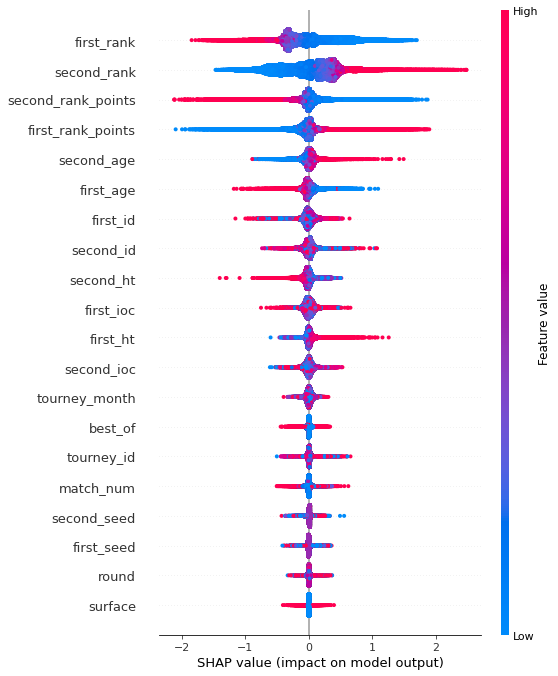

In [42]:
shap.summary_plot(shap_values, X_train)

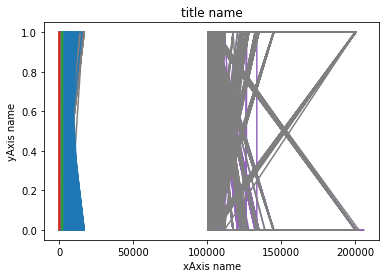

In [65]:
#plt.plot(X_test, RF_predictions)
#plt.title('title name')
#plt.xlabel('xAxis name')
#plt.ylabel('yAxis name')
#plt.show()

In [52]:
#feature_importances = pd.DataFrame(RF_classifier.feature_importances_,index = df_X.columns,columns=['importance']).sort_values('importance',ascending=False)

In [63]:
#feat_importances = pd.Series(RF_classifier.feature_importances_, index=X.columns)
#feature_importances.nlargest(25, RF_predictions.plot(kind='line')

SyntaxError: unexpected EOF while parsing (<ipython-input-63-9adb91de6e23>, line 2)